## INSTRUCTIONS 

This notebook contains the supervised learning models as part of the ATE sub-task for the CS4248 Final Project on Aspect Based Sentiment Analysis.

To run the code, please first install the required packages given in the cell below and set the correct paths in cells 2 and 3. 

Since our project explores 2 methods of sequence tagging with different feature engineering, there are 2 evaluation functions and 4 feature selection functions. Depending on the use case, please uncomment and run the required cells only!

In [ ]:
!pip install sklearn-crfsuite
!pip install -U 'scikit-learn<0.24'

!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install keras==2.2.4
!pip install tensorflow==1.13.1

#Uncomment the following lines to download the GloVe Embeddings -
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip -d ./data/glove
# !ls -lat ./data/glove

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
path_to_file = '/content/drive/My Drive/Colab Notebooks/NLP/Project'
os.chdir(path_to_file)

Mounted at /content/drive


In [ ]:
GLOVE_PATH = "/content/drive/MyDrive/Colab Notebooks/NLP/Project/glove/glove.6B.300d.txt"
NUM_DIM = 300 #Number of dimensions in chosen Glove Embedding
TRAIN_DATA_PATH = "Restaurants_Test.xml"
TEST_DATA_PATH = "Restaurants_Test_Gold.xml"
PRE_PROC_TRAIN_PATH = "pre_processed.csv"
PRE_PROC_TEST_PATH = "pre_processed_test.csv"

In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Flatten
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import spacy
nlp = spacy.load("en_core_web_sm")
from textblob import TextBlob

import xml.etree.ElementTree as ET
import pandas as pd

from ast import literal_eval

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, LSTM, Dropout, Embedding, Bidirectional, CuDNNLSTM

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## LOAD DATA

- data_train, data_test -> original data
- df_train, df_test -> pre-processed data

In [ ]:
def preprocess(filename):
    """
    desc:
    ====
    Takes in the filename, outputs a list of dictionaries. The dictionary will contain
    [review_id, raw_text, aspect_term, aspect_polarity]
    """
    tree = ET.parse(filename)
    root = tree.getroot()
    processed_data = [] # Store the final list of dictionaries
    
    for sentence in root.findall('sentence'):
        data = {}
        raw_text = sentence[0].text
        aspects = []
        aspect_polarity = []
        sentence_id = sentence.attrib['id']
        all_terms = sentence.find('aspectTerms')
        
        if all_terms: # If there are aspect terms
            all_terms_lst = all_terms.findall('aspectTerm')
            for ele in all_terms_lst: # Iterate through all aspect terms in senetence
                term = ele.get('term')
                aspects.append(term)
                term_polarity = ele.get('polarity')
                aspect_polarity.append(term_polarity)
        data['review_id'] = sentence_id
        data['raw_text'] = raw_text
        data['aspect_term'] = aspects
        data['aspect_polarity'] = aspect_polarity
        
        processed_data.append(data)
    return processed_data 

In [ ]:
processed_data = preprocess(TRAIN_DATA_PATH)
data_train = pd.DataFrame(processed_data)

processed_data = preprocess(TEST_DATA_PATH)
data_test = pd.DataFrame(processed_data)


In [ ]:
converters = {
    'AspectTerms':lambda x: literal_eval(x),
    'AspectTermsPolarity':lambda x: literal_eval(x),
    'TextWithPOS': lambda x:literal_eval(x),
    'FixedTextWithPOS': lambda x:literal_eval(x),
    'FixedTexttWithPOSReplaced': lambda x:literal_eval(x),
    'AspectTermsSpan': lambda x:literal_eval(x),
    'RawTextWithLabelIOB':lambda x:literal_eval(x)
    }


df_train = pd.read_csv(PRE_PROC_TRAIN_PATH, converters=converters)


df_test = pd.read_csv(PRE_PROC_TEST_PATH, converters=converters)

## TESTING METRICS

In [ ]:
def prec_rec(aspects,labels):
    tp = 0
    fn = 0
    fp = 0
    for i in range(len(aspects)):
        if len(aspects[i]) == 0 and len(labels[i]) == 0:
            pass
        elif len(aspects[i]) == 0 and len(labels[i]) > 0:
            fn += len(labels[i])
        elif len(aspects[i]) > 0 and len(labels[i]) == 0:
            fp += len(aspects[i])
        else:
            for term in aspects[i]:
                if term in labels[i]:
                    tp += 1
                else:
                    fp += 1
            for term in labels[i]:
                if term in aspects[i]:
                    pass
                else:
                    fn += 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return precision, recall

In [ ]:
def extractTermsIOB(y_pred, sent_row):
    aspects = []
    for i, y in enumerate(y_pred):
        sent_aspects = []
        for j, pred in enumerate(y):
            if pred=='B' or pred=='I':
                sent_aspects.append(sent_row[i][j][0])

        aspects.append(sent_aspects)
    return aspects

#result = extractTermsIOB(y_pred, test_list)
#prec_rec(df_test.AspectTerms, result)

In [ ]:
def extractTermsBin(y_pred, sent_row):
    aspects = []
    for i, y in enumerate(y_pred):
        sent_aspects = []
        for j, pred in enumerate(y):
            if pred=='A':
                sent_aspects.append(sent_row[i][j][0])

        aspects.append(sent_aspects)
    return aspects

#result = extractTermsBin(y_pred, test_list)
#prec_rec(df_test.AspectTerms, result)

## CREATING INPUT FEATURES

In [ ]:
df = pd.DataFrame(columns=['id', 'word','pos','iob','tag'])
df_list = []

def createDF(row):
    global df
    aspects = row.AspectTerms
    ret_list = []
    for i, word in enumerate(row.RawTextWithLabelIOB):
        id = row.ID
        w = word[0]
        pos = row.TextWithPOS[i][1]
        iob = word[1]
        if w in aspects:
            df = df.append({'id': id, 'word':w, 'pos':pos, 'iob':iob, 'tag':'A'}, ignore_index=True)
            ret_list.append((w, pos, iob, 'A'))
        else:
            df = df.append({'id': id, 'word':w, 'pos':pos, 'iob':iob, 'tag':'NA'}, ignore_index=True)
            ret_list.append((w, pos, iob, 'NA'))
        
    return ret_list

for index, row in df_train.iterrows():
    global df_list
    df_list.append(createDF(row))

In [ ]:
test = pd.DataFrame(columns=['id', 'word','pos','iob'])
test_list = []

def createDF(row):
    global test
    aspects = row.AspectTerms
    ret_list = []
    for i, word in enumerate(row.RawTextWithLabelIOB):
        id = row.ID
        w = word[0]
        pos = row.TextWithPOS[i][1]
        iob = word[1]
        if w in aspects:
            test = test.append({'id': id, 'word':w, 'pos':pos, 'iob':iob, 'tag':'A'}, ignore_index=True)
            ret_list.append((w, pos, iob, 'A'))
        else:
            test = test.append({'id': id, 'word':w, 'pos':pos, 'iob':iob, 'tag':'NA'}, ignore_index=True)
            ret_list.append((w, pos, iob, 'NA'))

    return ret_list


for index, row in df_test.iterrows():
    global test_list
    test_list.append(createDF(row))

## FEATURE SELECTION - 

Please run only the cell of the fetures to be added.

##### TAG

In [ ]:
## TAG

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    iobtag = sent[i][2]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        iobtag1 = sent[i-1][2]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        iobtag1 = sent[i+1][2]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features



##### IOB + TAG

In [ ]:
## IOB + TAG

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    iobtag = sent[i][2]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'iobtag': iobtag,
        'iobtag[:2]': iobtag[:2]
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        iobtag1 = sent[i-1][2]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:iobtag': iobtag1,
            '-1:iobtag[:2]': iobtag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        iobtag1 = sent[i+1][2]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:iobtag': iobtag1,
            '+1:iobtag[:2]': iobtag1[:2],
        })
    else:
        features['EOS'] = True

    return features


##### POS + TAG

In [ ]:
# POS + TAG

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    iobtag = sent[i][2]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        iobtag1 = sent[i-1][2]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        iobtag1 = sent[i+1][2]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


##### POS + IOB + TAG

In [ ]:
## POS + IOB + TAG

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    iobtag = sent[i][2]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
        'iobtag': iobtag,
        'iobtag[:2]': iobtag[:2]
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        iobtag1 = sent[i-1][2]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            '-1:iobtag': iobtag1,
            '-1:iobtag[:2]': iobtag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        iobtag1 = sent[i+1][2]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
            '+1:iobtag': iobtag1,
            '+1:iobtag[:2]': iobtag1[:2],
        })
    else:
        features['EOS'] = True

    return features


### Creating features

In [ ]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent, tag):
    if tag == 'iob':
        return [iobtag for token, postag, iobtag, label in sent]
    else:
        return [label for token, postag, iobtag, label in sent]
def sent2tokens(sent):
    return [token for token, postag, iobtag, label in sent]

## TEST TRAIN SPLITS

In [ ]:
X_train = [sent2features(s) for s in df_list]
y_train = [sent2labels(s, 'iob') for s in df_list] ## FOR IOB TAGS

## y_train = [sent2labels(s, 'bin') for s in df_list] ## FOR BINARY (aspect) TAGS


In [ ]:
X_test = [sent2features(s) for s in test_list]
y_test = [sent2labels(s, 'iob') for s in test_list]

#y_test = [sent2labels(s, 'bin) for s in test_list]

## MODELS

### CRF

In [ ]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics


In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [ ]:
labels = list(crf.classes_)
labels

['O', 'B', 'I']

In [ ]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.930218709187356

In [ ]:
#result = extractTermsBin(y_pred, test_list) ## For binary classification

result = extractTermsIOB(y_pred, test_list) ## for IOB classification
prec_rec(df_test.AspectTerms, result)

(0.5784832451499118, 0.5385878489326765)

### Bi-LSTM

In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Flatten
from keras_contrib.layers import CRF
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Read data
data_train = df
data_test = test

In [ ]:
from tqdm import tqdm

glove_path = GLOVE_PATH

embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_index[token] = vector

In [ ]:
# Vocab
word_train = set(data_train['word'].values)
word_test = set(data_test['word'].values)
words = list(word_train or word_test)

In [ ]:
word_true = 0

for word in words:
    if word in embeddings_index:
        word_true += 1

In [ ]:
print(len(words))
print(word_true)

5321
3759


In [ ]:
word2idx = {}
word2idx['<PAD>'] = 0
word2idx['<UNK>'] = 1
for i, word in enumerate(words):
    word2idx[word] = i + 2

In [ ]:
np.zeros(10)
EMBEDDING_DIM = NUM_DIM

embedding_matrix = np.zeros((len(words)+2, EMBEDDING_DIM))

for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
        embedding_matrix[i] = embeddings_index['unk']
    else:
        embedding_matrix[i] = embedding_vector

# embedding_matrix[0] is all zeros for padding
embedding_matrix[0] = np.zeros(EMBEDDING_DIM)

In [ ]:
data = data_train

# Save all words as a list
max_len = 75
n_words = len(word2idx)
tags = list(set(data["iob"].values))
n_tags = len(tags)

tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx['<pad>'] = 0
n_tags = len(tag2idx) # Due to <pad>, here total tag number is from 17 to 18




In [ ]:
# Word2inx & Padding for X
X = [[word2idx[w[0]] for w in s] for s in df_list]
X_train = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

# Word2inx & Padding for y
y = [[tag2idx[w[2]] for w in s] for s in df_list]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)

# Get one-hot labels
y_train = [to_categorical(i, num_classes=n_tags) for i in y]

In [ ]:
#==============Bi-LSTM CRF=============
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, 
                  output_dim=NUM_DIM,
                  weights=[embedding_matrix],
                  input_length=max_len, 
                  mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=256, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="tanh"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 300)           1596900   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 512)           1140736   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            25650     
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 4)             228       
Total params: 2,763,514
Trainable params: 2,763,514
Non-trainable params: 0
___________

In [ ]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=8,
                    validation_split=0.1, verbose=1)

Train on 2739 samples, validate on 305 samples
Epoch 1/8
2739/2739 [==============================] - 155s 57ms/step - loss: 8.8009 - crf_viterbi_accuracy: 0.9928 - val_loss: 9.2429 - val_crf_viterbi_accuracy: 0.9546
Epoch 2/8
2739/2739 [==============================] - 128s 47ms/step - loss: 8.7968 - crf_viterbi_accuracy: 0.9949 - val_loss: 9.2663 - val_crf_viterbi_accuracy: 0.9533
Epoch 3/8
2739/2739 [==============================] - 125s 46ms/step - loss: 8.7943 - crf_viterbi_accuracy: 0.9965 - val_loss: 9.2676 - val_crf_viterbi_accuracy: 0.9510
Epoch 4/8
2739/2739 [==============================] - 131s 48ms/step - loss: 8.7931 - crf_viterbi_accuracy: 0.9973 - val_loss: 9.2755 - val_crf_viterbi_accuracy: 0.9531
Epoch 5/8
2739/2739 [==============================] - 128s 47ms/step - loss: 8.7916 - crf_viterbi_accuracy: 0.9977 - val_loss: 9.2925 - val_crf_viterbi_accuracy: 0.9505
Epoch 6/8
2739/2739 [==============================] - 126s 46ms/step - loss: 8.7909 - crf_viterbi_accu

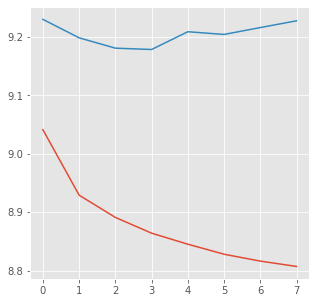

In [ ]:
hist = pd.DataFrame(history.history)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(5,5))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

In [ ]:
# Word2inx & Padding for X
X = [[word2idx.get(w[0], 1) for w in s] for s in test_list]
X_test = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

# Word2inx & Padding for y
y = [[tag2idx[w[2]] for w in s] for s in test_list]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)

# Get one-hot labels
y_test = [to_categorical(i, num_classes=n_tags) for i in y]

In [ ]:
test_list[0], X_test[0]

([('The', 'DT', 'O', 'NA'),
  ('bread', 'NN', 'B', 'A'),
  ('is', 'VBZ', 'O', 'NA'),
  ('top', 'JJ', 'O', 'NA'),
  ('notch', 'NN', 'O', 'NA'),
  ('as', 'RB', 'O', 'NA'),
  ('well', 'RB', 'O', 'NA')],
 array([5261,  956, 1593, 1545, 4489, 2119, 2195,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32))

In [ ]:
# Predictions.
idx2word = {value: key for key, value in word2idx.items()}
idx2tag = {value: key for key, value in tag2idx.items()}


true_all = np.argmax(y_test, -1)

true_all_tags = [[idx2tag[idx] for idx in s if idx!=0] for s in true_all]

p_all = model.predict(np.array(X_test)) # (4796, 75, 18)
p_all= np.argmax(p_all, axis=-1) # (4796, 75)
p_all_tags = [[idx2tag[idx] for idx in s] for s in p_all] # ['B-gpe', 'O', 'O', 'O']

for i, true in enumerate(true_all_tags):
    length = len(true)
    p_all_tags[i] = p_all_tags[i][:length]

p_all_tags = [[x.replace('<pad>', 'O') for x in s] for s in p_all_tags]

# for (true_tag, p)

print(test_list[0])
print(X_test[0])
print(true_all_tags[0])
print(p_all_tags[0])

[('The', 'DT', 'O', 'NA'), ('bread', 'NN', 'B', 'A'), ('is', 'VBZ', 'O', 'NA'), ('top', 'JJ', 'O', 'NA'), ('notch', 'NN', 'O', 'NA'), ('as', 'RB', 'O', 'NA'), ('well', 'RB', 'O', 'NA')]
[5261  956 1593 1545 4489 2119 2195    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
['O', 'B', 'O', 'O', 'O', 'O', 'O']
['O', 'B', 'O', 'O', 'O', 'O', 'O']


In [ ]:
#result = extractTermsBin(p_all_tags, test_list)

result = extractTermsIOB(p_all_tags, test_list)
prec_rec(df_test.AspectTerms, result)

(0.6031746031746031, 0.4899713467048711)